In [1]:
import numpy as np
import pandas as pd

In [2]:
!ls

 data  'Eminem Word2Vec.ipynb'	 preprocess.py


In [33]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
print( str(device_lib.list_local_devices()))

# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# confirm PyTorch sees the GPU
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9703949567822274568
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3290444151592624310
physical_device_desc: "device: XLA_CPU device"
]


AssertionError: 

In [3]:
songs = pd.read_csv('data/eminem-songs.csv')

In [4]:
songs.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,song,album,lyrics
0,0,0,0,0,the-ringer,kamikaze,"Yo|-|Yo, I'm just gonna write down |-|my first..."
1,1,1,1,1,greatest,kamikaze,"Motherfuckers talkin' crazy (yeah), sayin' I s..."
2,2,2,2,2,luck-you,kamikaze,NaN
3,3,3,3,3,normal,kamikaze,"Yo, how do I keep (I don't know what's up with..."
4,4,4,4,4,stepping-stone,kamikaze,"Its 2002, everything was totally new|-|We were..."


In [5]:
songs.dtypes

Unnamed: 0           int64
Unnamed: 0.1         int64
Unnamed: 0.1.1       int64
Unnamed: 0.1.1.1     int64
song                object
album               object
lyrics              object
dtype: object

In [6]:
import re
from unidecode import unidecode

words = []

for index, row in songs['lyrics'].iteritems():
    row = str(row).lower()
    new_words = re.findall(r"\b[a-z']+[a-z']+\b", unidecode(row))
    words = words + new_words
    print('processing: {} -> {}. {} new words'.format(index, row[:20], len(new_words)))

processing: 0 -> yo|-|yo, i'm just go. 1334 new words
processing: 1 -> motherfuckers talkin. 892 new words
processing: 2 -> nan. 1 new words
processing: 3 -> yo, how do i keep (i. 670 new words
processing: 4 -> its 2002, everything. 865 new words
processing: 5 -> tay keith, fuck thes. 1130 new words
processing: 6 -> okay, how do i say t. 656 new words
processing: 7 -> you know, everybody'. 899 new words
processing: 8 -> you're such a nice g. 385 new words
processing: 9 -> here we go, a get in. 446 new words
processing: 10 -> i got a song filled . 824 new words
processing: 11 -> it's like i'm in thi. 1353 new words
processing: 12 -> (what's your name?) . 866 new words
processing: 13 -> you fucking groupie.. 764 new words
processing: 14 -> this is survival of . 733 new words
processing: 15 -> tell me where to go,. 756 new words
processing: 16 -> i came to the world . 960 new words
processing: 17 -> now this shit's abou. 777 new words
processing: 18 -> look, i was gonna go. 1430 new words

/home/ubuntu/Code/virtual_envs/MachineLearning/local/lib/python2.7/site-packages/unidecode/__init__.py:46: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.
  _warn_if_not_unicode(string)


In [7]:
vocab = set(words)

word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for w, i in word_to_index.items()}
word_indices = [word_to_index[word] for word in vocab]
vocab_n = len(vocab)

In [8]:
ntk = [vocab_n]
X_indices_of_ones = np.array(word_indices + word_indices)
previous_word = ntk + word_indices[:-1]
next_word = word_indices[1:] + ntk
y_indices_of_ones = np.array(previous_word + next_word)

In [9]:
X = np.zeros((X_indices_of_ones.shape[0], vocab_n + 1))
X[np.arange(X.shape[0]), X_indices_of_ones] = 1

y = np.zeros((y_indices_of_ones.shape[0], vocab_n + 1))
y[np.arange(y.shape[0]), y_indices_of_ones] = 1

In [10]:
print(X.shape)
print(y.shape)

(11950, 5976)
(11950, 5976)


In [11]:
batch_size = 10
divisible_size = 11280

X_b = X[:divisible_size, :].reshape(int(divisible_size / batch_size), batch_size, vocab_n + 1)
y_b = y[:divisible_size, :].reshape(int(divisible_size/batch_size), batch_size, vocab_n + 1)

In [12]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

encoding_size = 8

model = Sequential()
model.add(Dense(encoding_size, input_shape=(batch_size, vocab_n + 1), activation='relu'))
model.add(Dense(vocab_n + 1, activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Using TensorFlow backend.


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10, 8)             47816     
_________________________________________________________________
dense_2 (Dense)              (None, 10, 5976)          53784     
Total params: 101,600
Trainable params: 101,600
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_b, y_b, nb_epoch=100)

/home/ubuntu/Code/virtual_envs/MachineLearning/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/100
1128/1128 [==============================] - 5s 4ms/step - loss: 8.6994 - acc: 0.0000e+00
Epoch 2/100
1128/1128 [==============================] - 4s 4ms/step - loss: 8.6953 - acc: 2.6596e-04
Epoch 3/100
1128/1128 [==============================] - 4s 4ms/step - loss: 8.6929 - acc: 3.5461e-04
Epoch 4/100
1128/1128 [==============================] - 4s 4ms/step - loss: 8.6886 - acc: 1.7730e-04
Epoch 5/100
1128/1128 [==============================] - 4s 4ms/step - loss: 8.6831 - acc: 8.8652e-05
Epoch 6/100
1128/1128 [==============================] - 4s 4ms/step - loss: 8.6754 - acc: 6.2057e-04
Epoch 7/100
1128/1128 [==============================] - 4s 4ms/step - loss: 8.6655 - acc: 5.3191e-04
Epoch 8/100
1128/1128 [==============================] - 4s 4ms/step - loss: 8.6533 - acc: 5.3191e-04
Epoch 9/100
1128/1128 [==============================] - 5s 4ms/step - loss: 8.6388 - acc: 3.5461e-04
Epoch 10/100
1128/1128 [==============================] - 5s 4ms/step - loss: 8.62

In [15]:
encoding = model.layers[0].get_weights()[0]

In [16]:
encoding.shape

(5976, 8)

In [17]:
def closest_word_to_vector(word_vector, num_nearby):
    distances = np.linalg.norm(encoding - word_vector, axis=1)
    closest = np.argsort(distances)[:num_nearby]
    return [index_to_word[i] for i in closest]

def closest_word(word, num_nearby):
    ind = word_to_index[word]
    word_vector = encoding[ind]
    return closest_word_to_vector(word_vector, num_nearby)

closest_word('currency', 6)

KeyError: 'currency'

In [18]:
def x_is_to_y_as_z_is_to(x, y, z, num_closest):
    x_v = encoding[word_to_index[x]]
    y_v = encoding[word_to_index[y]]
    z_v = encoding[word_to_index[z]]
    
    relationship_vector = x_v - y_v
    z_is_to = z_v + relationship_vector
    
    return closest_word_to_vector(z_is_to, num_closest)

x_is_to_y_as_z_is_to("big", "rings", "america", 5)

['bach', 'tom', 'cupping', 'curtains', 'vietnam']

In [19]:
prediction_model = Sequential()
prediction_model.add(Dense(encoding_size, input_dim=vocab_n + 1, activation='relu'))
prediction_model.add(Dense(vocab_n + 1, activation='softmax'))

prediction_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

prediction_model.set_weights(model.get_weights())

def words_likely_to_be_in_the_context_of(word, num_context):
    input_vector = np.zeros((1, vocab_n + 1))
    input_vector[0, word_to_index[word]] = 1
    output_vector = prediction_model.predict(input_vector)[0]
    top_context = np.argsort(-output_vector)[:num_context]
    return [index_to_word[i] for i in top_context]

words_likely_to_be_in_the_context_of('america', 10)

['loco',
 'sucks',
 'lock',
 'slit',
 'mackeral',
 'forever',
 'thanks',
 'yogurt',
 'dollars',
 'starting']

In [20]:
def cosine_similarity(u, v):
    
    distance = 0.0
    dot = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    
    norm_v = np.linalg.norm(v)
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity

In [21]:
cosine_similarity(encoding[word_to_index['school']], encoding[word_to_index['ignore']])

0.03462504

## Attempting TSNE

In [23]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, perplexity=100).fit_transform(encoding)
X_embedded.shape

/home/ubuntu/Code/virtual_envs/MachineLearning/local/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


(5976, 2)

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 25))

for i in range(0, len(X_embedded)):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], s=50)
    
    if (i % 20 == 0):
        plt.annotate(
            index_to_word[i], 
            (
                X_embedded[i, 0], 
                X_embedded[i, 1]
            ), 
            bbox=dict(boxstyle="round", 
                      fc=(1.0, 0.7, 0.7),
                      ec=(1., .5, .5)), 
            fontsize=15
        )
        

plt.show()

<Figure size 5000x2500 with 1 Axes>

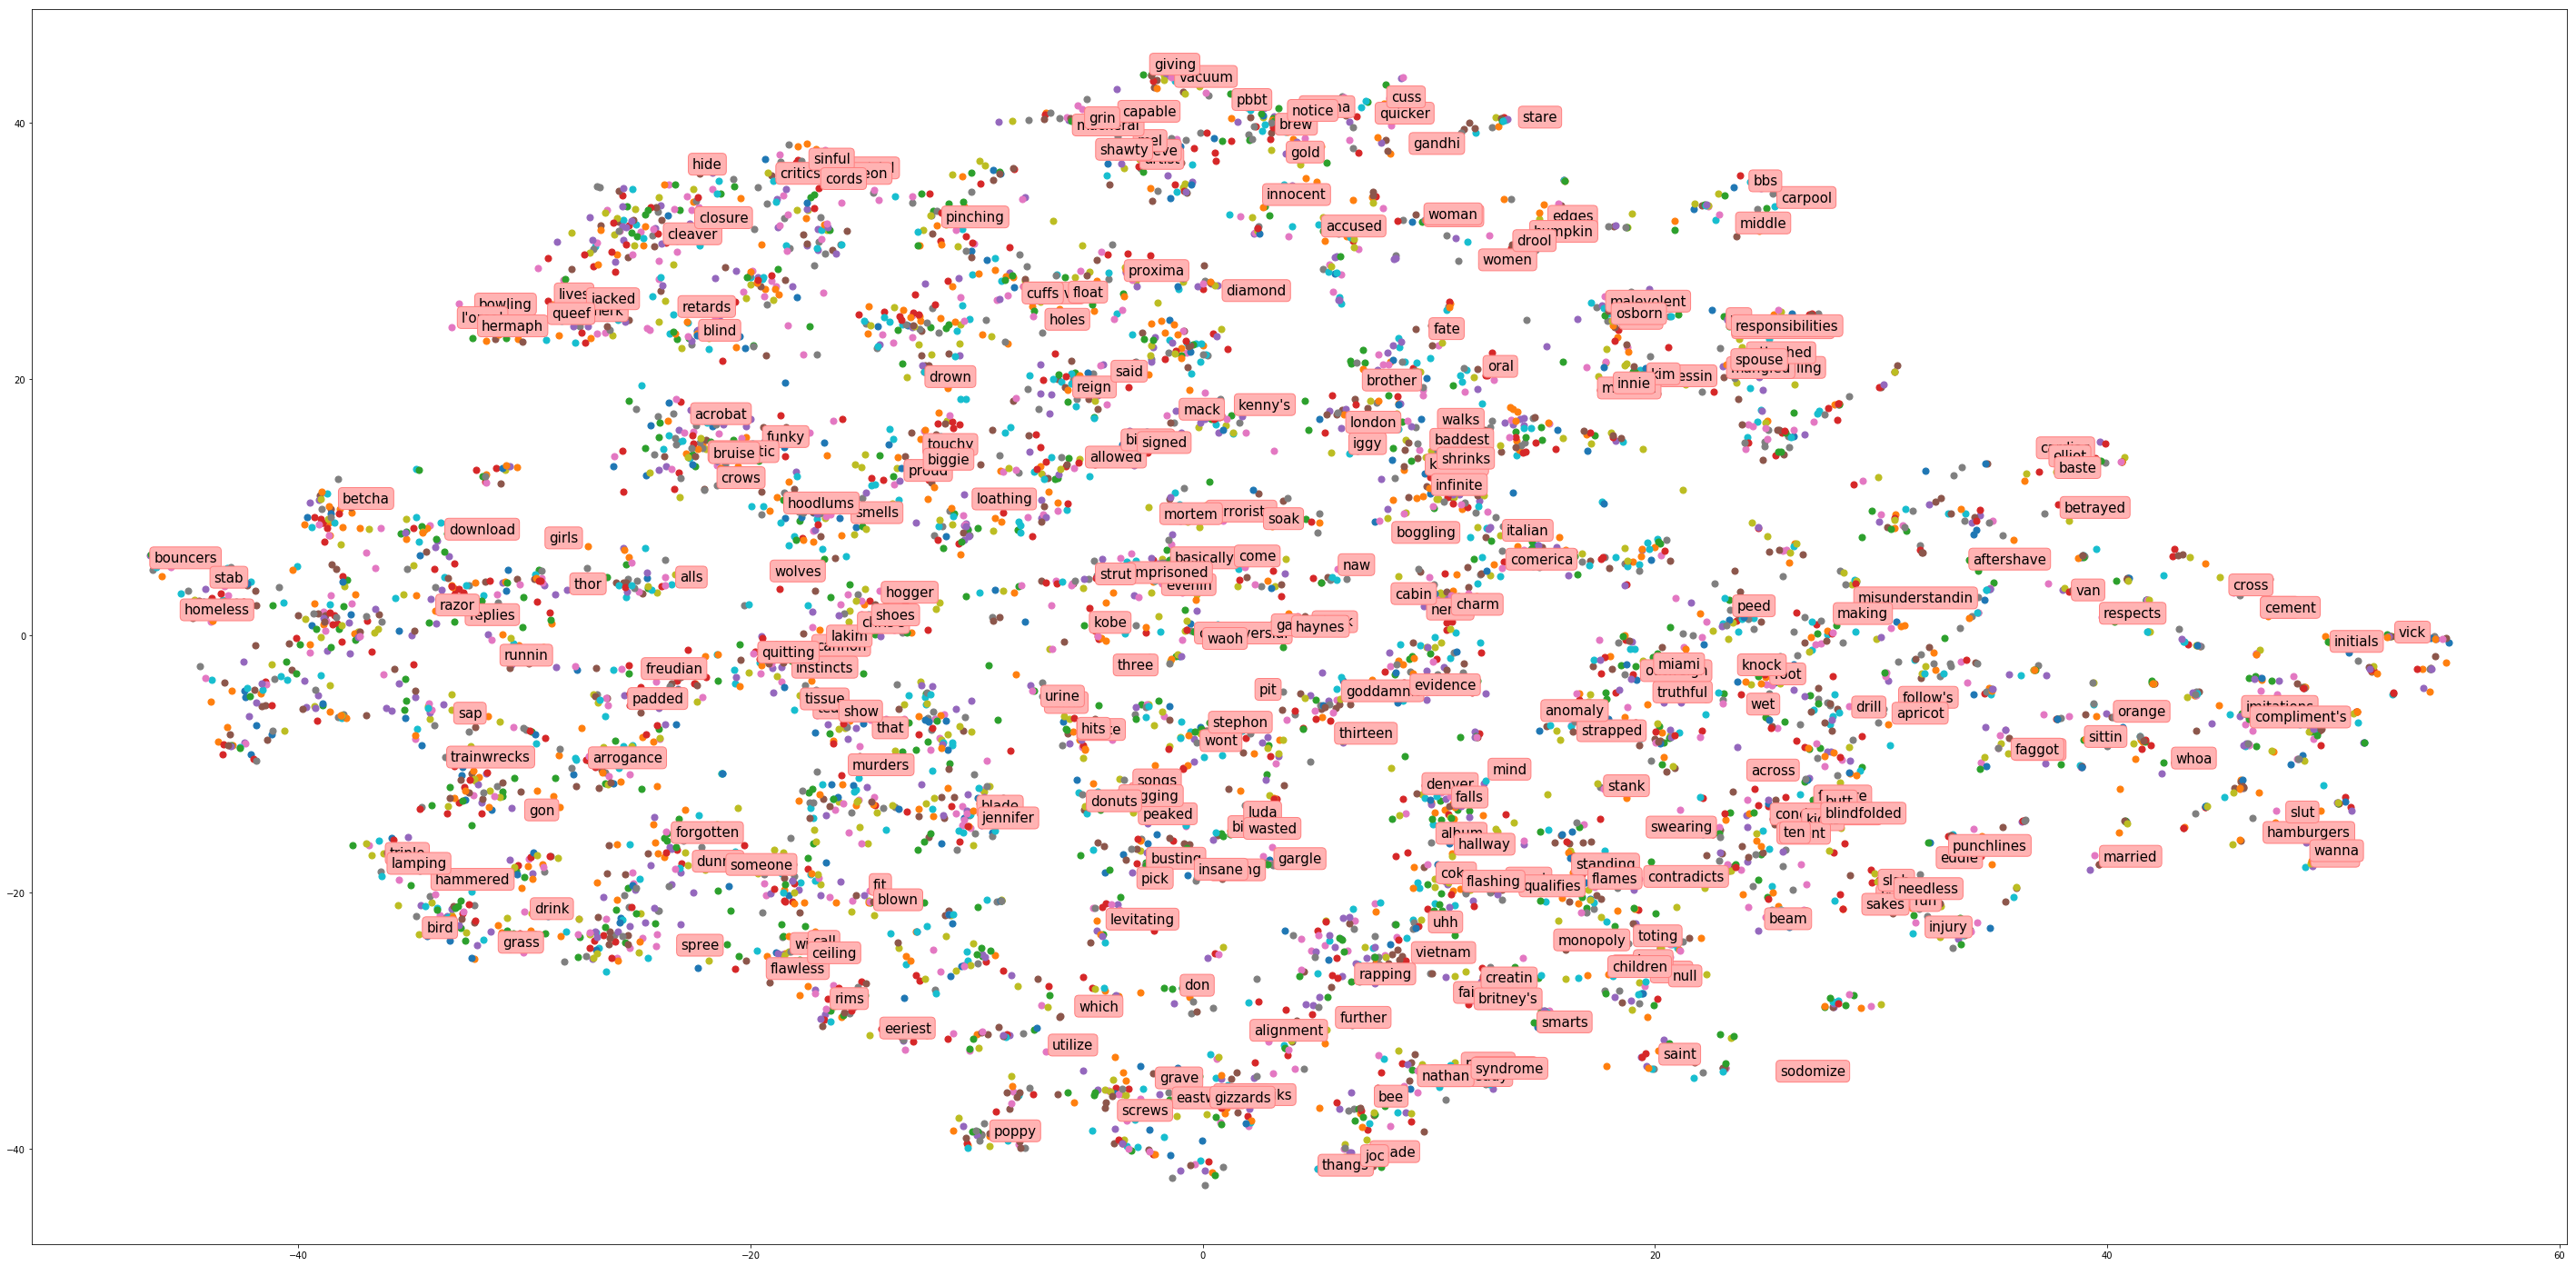

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 25))

for i in range(0, len(X_embedded)):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], s=50)
    
    if (i % 20 == 0):
        plt.annotate(
            index_to_word[i], 
            (
                X_embedded[i, 0], 
                X_embedded[i, 1]
            ), 
            bbox=dict(boxstyle="round", 
                      fc=(1.0, 0.7, 0.7),
                      ec=(1., .5, .5)), 
            fontsize=15
        )
        

plt.show()

KeyError: 5975

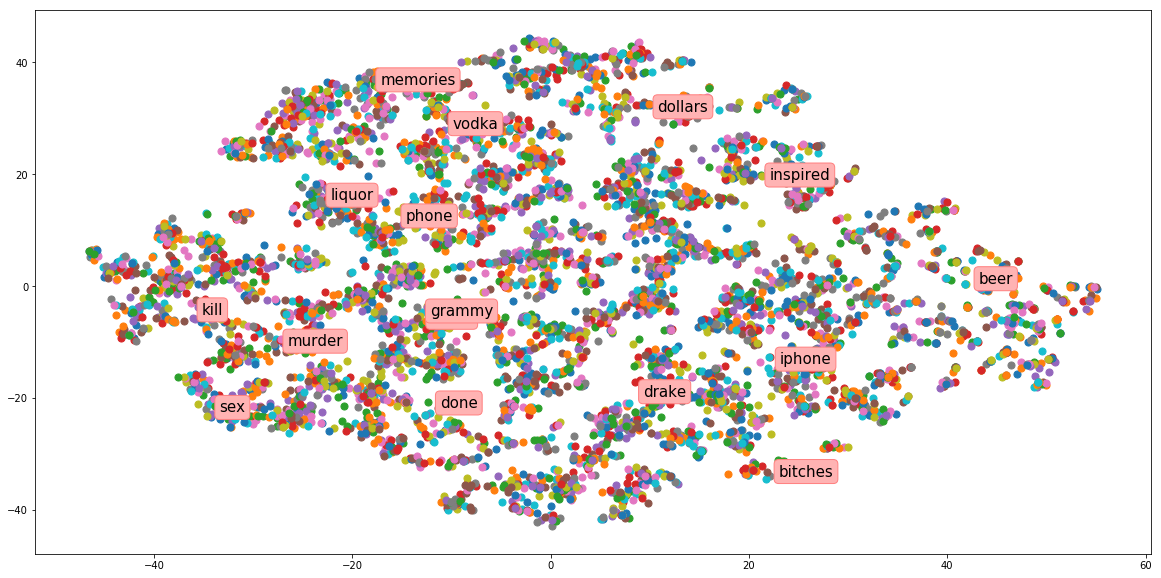

In [28]:
import matplotlib.pyplot as plt

words_of_interest = [
    'drake', 
    'toronto', 
    'quavo', 
    'bitches', 
    'sex', 
    'kill', 
    'murder', 
    'phone', 
    'blackberry', 
    'beer', 
    'liquor', 
    'vodka',
    'batphone',
    'done',
    'memories',
    'inspired',
    'summary',
    'grammy',
    'iphone',
    'emmys',
    'currency',
    'dollar',
    'dollars',
    'euro'
]

plt.figure(figsize=(20, 10))

for i in range(0, len(X_embedded)):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], s=50)
    
    if (index_to_word[i] in words_of_interest):
        plt.annotate(
            index_to_word[i], 
            (
                X_embedded[i, 0], 
                X_embedded[i, 1]
            ), 
            bbox=dict(boxstyle="round", 
                      fc=(1.0, 0.7, 0.7),
                      ec=(1., .5, .5)), 
            fontsize=15
        )
        

plt.show()